# Bike Rental Data Management Project

## Importing libraries and data

In [1]:
import os
import datetime
import string

import pandas as pd
import numpy as np

import sqlalchemy

Next, we will be loading the monthly datasets for Citi Bike and concatenate them in a single `pandas` dataframe. It is important to note that this information is from 2016. I will try to run a similar analysis for 2022 data eventually.

In [2]:
df_bike = pd.DataFrame()

In [3]:
# use for-loop to create unified dataframe through df_temp
for f in sorted(os.listdir('../datafiles/citibike_and_weather_data_2016')):
    if f.startswith('JC'):
        df_temp = pd.read_csv('../datafiles/citibike_and_weather_data_2016/' + f)
        df_bike = pd.concat([df_bike, df_temp], axis=0)

# reset index after concatenation
df_bike.reset_index(drop=True, inplace=True)

# add an 'id' column for counts and future primary key usage
df_bike['id'] = df_bike.index

Inspect both the beginning and end of our dataframe:

In [4]:
df_bike.head(5)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,id
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0,4


In [5]:
df_bike.tail(5)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,id
247579,557,2016-12-31 23:10:16,2016-12-31 23:19:33,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24465,Subscriber,1981.0,2,247579
247580,2749,2016-12-31 23:29:39,2017-01-01 00:15:29,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,24389,Customer,NaN,0,247580
247581,173,2016-12-31 23:44:37,2016-12-31 23:47:31,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,24641,Subscriber,1978.0,1,247581
247582,2424,2016-12-31 23:44:50,2017-01-01 00:25:14,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,26219,Subscriber,1960.0,2,247582
247583,2419,2016-12-31 23:44:50,2017-01-01 00:25:10,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,24471,Subscriber,1956.0,1,247583


We can check that there are almost 250k records in this df. There are also some observations to take into account based on the data dictionary that came with the starter kit:
* `Trip Duration` is in seconds
* `Gender` can be `0=unknown`, `1=male`, and `2=female`
* `User Type` has values `Customer= 24 hr pass or 3-day user` and `Subscriber=Annual member`

I will now calculate some basic descriptive statistics for numerical columns from the df:

In [6]:
df_bike.describe()

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,id
count,2.475840e+05,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,228585.000000,247584.000000,247584.000000
mean,8.856305e+02,3207.065206,40.723121,-74.046438,3203.572553,40.722594,-74.045855,24935.260481,1979.335276,1.123534,123791.500000
std,3.593798e+04,26.955103,0.008199,0.011211,61.579494,0.007958,0.011283,748.469712,9.596809,0.518687,71471.488861
min,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,40.692216,-74.096937,14552.000000,1900.000000,0.000000,0.000000
25%,2.480000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24491.000000,1974.000000,1.000000,61895.750000
50%,3.900000e+02,3201.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043117,24609.000000,1981.000000,1.000000,123791.500000
75%,6.660000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24719.000000,1986.000000,1.000000,185687.250000
max,1.632981e+07,3426.000000,40.752559,-74.032108,3426.000000,40.801343,-73.957390,27274.000000,2000.000000,2.000000,247583.000000


Some things to note from the above description:
* There is something interesting going on with the `Trip Durantion`, given it jump five orders of magnitude between the 75th percentile and the max
* The minimum `Birth Year` is 1900, which equates to an age of 116
* The minimum for the `End Station ID` is 147, which is not congruent with the minimum for the `Start Station ID`. This is something that I will need to look into to avoid errors in my analysis
* Latitud and Longitude both show small stdev, so it is safe to assume there are no major discrepancies between these set of values

Moving along, I will now scout for missing values and duplicates:

In [7]:
df_bike.isna().sum()

Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station ID               0
Start Station Name             0
Start Station Latitude         0
Start Station Longitude        0
End Station ID                 0
End Station Name               0
End Station Latitude           0
End Station Longitude          0
Bike ID                        0
User Type                    380
Birth Year                 18999
Gender                         0
id                             0
dtype: int64

In [8]:
df_bike.duplicated().sum()

0

At first glance, it is clear there is some major problems with the `Birth Year` of some users, as well as the `User Type `in fewer instances. Keep in mind that the `Gender` column has values of `0` which correspondon to an `Unknown` genre, so this is also something that will be addressed further down the road.

For now, let's continue with the exploratory analysis and see what data types are present in the df:

In [9]:
df_bike.dtypes

Trip Duration                int64
Start Time                  object
Stop Time                   object
Start Station ID             int64
Start Station Name          object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID               int64
End Station Name            object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                      int64
User Type                   object
Birth Year                 float64
Gender                       int64
id                           int64
dtype: object

It is key to note that both `Start Time` and `Stop Time` need to be casted into `datetime64` data type. I will also have to address the problem with `Birth Year` (which should be an integer) once I have corrected all the missing values.

In [10]:
# casting objects as timestamps with pd.to_datetime()
df_bike['Start Time'] = pd.to_datetime(df_bike['Start Time'])
df_bike['Stop Time'] = pd.to_datetime(df_bike['Stop Time'])

df_bike.dtypes

Trip Duration                       int64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID                    int64
Start Station Name                 object
Start Station Latitude            float64
Start Station Longitude           float64
End Station ID                      int64
End Station Name                   object
End Station Latitude              float64
End Station Longitude             float64
Bike ID                             int64
User Type                          object
Birth Year                        float64
Gender                              int64
id                                  int64
dtype: object

# Cleaning and Transforming Bike Rental Data

Quick summary of our initial data exploration:
* `Birth Year`: suspicious minimum and missing data
* `User Type`: missing data
* `Trip Duration`: suspicious maximum
* `Gender`: what are the unknowns
* `End Station ID`: incongruent minimum

Now we will update columns names to something that will help us in the future once we stablish our db schema:

In [11]:
df_bike.columns = df_bike.columns.map(lambda x: x.replace(' ', '_').lower())
df_bike.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0,4


## Calculating `age` using `birth_year`

In [12]:
df_bike['age'] = 2016 - df_bike['birth_year'].values
df_bike['age'].sort_values(ascending=False)[:10]

215055    116.0
136211     82.0
164274     79.0
187190     79.0
180373     79.0
213567     79.0
177320     76.0
112336     76.0
149803     76.0
124501     75.0
Name: age, dtype: float64

We can consider the age of 116 to be an outlier for out dataset, so we will remove it since we are not expecting other riders with that age.

In [13]:
df_bike.drop([215055], inplace=True)

Now let's examine the missing data in `birth_year`:

In [14]:
missing_birth_year = df_bike[df_bike[['birth_year']].isnull().any(axis=1)]
missing_birth_year.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0,4,NaN
5,883,2016-01-01 01:03:28,2016-01-01 01:18:11,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24442,Customer,NaN,0,5,NaN
22,988,2016-01-01 03:16:33,2016-01-01 03:33:02,3196,Riverview Park,40.744319,-74.043991,3209,Brunswick St,40.724176,-74.050656,24662,Customer,NaN,0,22,NaN
53,3090,2016-01-01 11:07:15,2016-01-01 11:58:46,3203,Hamilton Park,40.727596,-74.044247,3203,Hamilton Park,40.727596,-74.044247,24444,Customer,NaN,0,53,NaN
57,788,2016-01-01 11:50:30,2016-01-01 12:03:39,3210,Pershing Field,40.742677,-74.051789,3195,Sip Ave,40.730743,-74.063784,24573,Customer,NaN,0,57,NaN


Let's look at the `user_type` and `gender` of this subset of users:

In [15]:
missing_birth_year['user_type'].value_counts()

user_type
Customer      15470
Subscriber     3529
Name: count, dtype: int64

In [16]:
missing_birth_year['gender'].value_counts()

gender
0    18999
Name: count, dtype: int64

From these results, we can notice that:
* all records with missing `birth_year` also have unknown `gender`
* customer `user_type` account for the vast majority of the missing `birth_year` data.

Let's take a look at the percentage of `user_type` with missing `birth_year` data:

In [17]:
missing_birth_year['user_type'].value_counts() / df_bike['user_type'].value_counts()

user_type
Customer      0.996714
Subscriber    0.015232
Name: count, dtype: float64

Now, since it is known that all users with missing `birth_year` are also users with unknown gender, we want to determine the percentage of users with unknown gender that have a missing `birth_year` for each `user_type`, starting with `Subscriber`s:

In [18]:
missing_birth_year[missing_birth_year['user_type'] == 'Subscriber']['gender'].value_counts() / df_bike[df_bike['user_type'] == 'Subscriber']['gender'].value_counts()

gender
0    0.796434
1         NaN
2         NaN
Name: count, dtype: float64

And then with `Customer`s:

In [19]:
missing_birth_year[missing_birth_year['user_type'] == 'Customer']['gender'].value_counts() / df_bike[df_bike['user_type'] == 'Customer']['gender'].value_counts()

gender
0    1.0
1    NaN
2    NaN
Name: count, dtype: float64

Notice that:
* 99.7% of customers are missing `birth_year`, most likely because that information is optional in the rental contract
* 1.5% of subscribers are missing `birth_year`, this must be the case because to become an annual member, they need to provide more information to the rental company
* all records with missing `birth_year` also have unknown `gender`
* 79.6% of subscribers with unknown `genre` have missing `birth_year`
* 100% of customers with unknown `genre` have missing `birth_year`

From these observations we can conclude that almost all customers have a missing `birth_year`, and that there is a clear pattern between users with unknown `genre` and missing `birth_year`. Regardless, it would be detrimental to the analysis to remove all entries with missing `birth_year` since we would be excluding most of our customers, as well as the majority of the subscribers (and users) with unknown `genre`. Still, it is important to keep this in mind when performing further analysis.

## Cleaning `user_type`

Moving right along with the missing `user_type` entries, we know there are 380 missing records, which represent less than 1% of the total. We are going to check if these records are also missing `birth_year` or have unknown `genre`:

In [20]:
missing_user_type = df_bike[df_bike[['user_type']].isnull().any(axis=1)]
missing_user_type['birth_year'].isna().sum()

0

In [21]:
missing_user_type.groupby(['gender']).count()['id']

gender
1    262
2    118
Name: id, dtype: int64

If we consider the previous pattern that users with missing `birth_year` also had unknown `genre`, and these were mostly customers, it is safe to assume that those with a missing `user_type` are subscribers, but it is possible that some are also customers.

Let's take a look at the missing data over the course of the year using a bar chart:

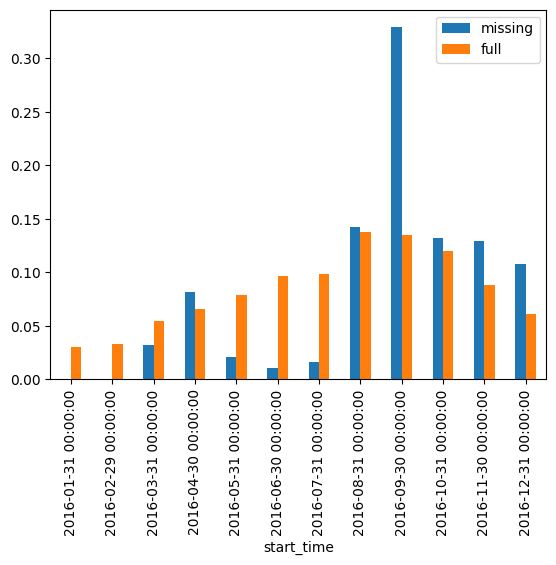

In [22]:
my = (missing_user_type.resample('M', on='start_time').count()['id'] / len(missing_user_type)).rename('missing')
dy = (df_bike.resample('M', on='start_time').count()['id'] / len(df_bike)).rename('full')
combo = pd.concat([my, dy], axis=1)

ax = combo.plot.bar();

There is no clear pattern that will help us shed some light on why `user_type` data might be missing, we can only assume that something might have occurred during the 2nd half of the year that caused so much data to be missing. Still, even if the amount of missing data is rather small, it is not viable to remove it. The best course of action is to replace the missing values with an `unknown` category to help the analytics team keep track of this issue further down the line.

In [23]:
df_bike.fillna({'user_type': 'Unknown'}, inplace=True)

In [24]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247583 entries, 0 to 247583
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   trip_duration            247583 non-null  int64         
 1   start_time               247583 non-null  datetime64[ns]
 2   stop_time                247583 non-null  datetime64[ns]
 3   start_station_id         247583 non-null  int64         
 4   start_station_name       247583 non-null  object        
 5   start_station_latitude   247583 non-null  float64       
 6   start_station_longitude  247583 non-null  float64       
 7   end_station_id           247583 non-null  int64         
 8   end_station_name         247583 non-null  object        
 9   end_station_latitude     247583 non-null  float64       
 10  end_station_longitude    247583 non-null  float64       
 11  bike_id                  247583 non-null  int64         
 12  user_type            

## Analyzing `gender`

In previous sections, we noticed that customers whose `gender` is unknown are also missing their `birth_year` information in the system. Now, we will look at the distribution of `gender` for each `user_type`:

In [25]:
df_bike.groupby(['user_type', 'gender']).count()['id']

user_type   gender
Customer    0          15470
            1             36
            2             15
Subscriber  0           4431
            1         176898
            2          50353
Unknown     1            262
            2            118
Name: id, dtype: int64

If we look at this information as a percentage, we get:

In [26]:
df_bike.groupby(['user_type', 'gender']).count()['id'] / df_bike['gender'].value_counts()

user_type   gender
Customer    0         0.777348
            1         0.000203
            2         0.000297
Subscriber  0         0.222652
            1         0.998318
            2         0.997366
Unknown     1         0.001479
            2         0.002337
dtype: float64

We can observe that 77.7% of users with unknown `gender` are customers, and 22.3% are subscribers. The following output also shows that this 77.7% of unknown genders represent the vast majority of our customers, so we cannot afford to scrap them from the database. We need to keep in mind that demographic information is only really useful for subscribers.

In [27]:
df_bike.groupby(['user_type', 'gender']).count()['id'] / df_bike['user_type'].value_counts()

user_type   gender
Customer    0         0.996714
            1         0.002319
            2         0.000966
Subscriber  0         0.019125
            1         0.763538
            2         0.217337
Unknown     1         0.689474
            2         0.310526
dtype: float64

## Investigating `trip_duration` suspicious maximum

Remember that `trip_duration` is given in seconds, so we can determine trip duration in minutes, hours and days with the appropriate operations:

In [30]:
df_bike_duration = pd.DataFrame()
df_bike_duration['trip_duration'] = df_bike['trip_duration']
df_bike_duration['trip_minutes'] = round(df_bike_duration['trip_duration'] / 60, 2)
df_bike_duration['trip_hours'] = round(df_bike_duration['trip_duration'] / (60**2), 2)
df_bike_duration['trip_days'] = round(df_bike_duration['trip_hours'] / 24, 2)

df_bike_duration.describe()

,trip_duration,trip_minutes,trip_hours,trip_days
count,2.475830e+05,247583.000000,247583.000000,247583.000000
mean,8.856300e+02,14.760494,0.246006,0.009163
std,3.593805e+04,598.967493,9.982797,0.415978
min,6.100000e+01,1.020000,0.020000,0.000000
25%,2.480000e+02,4.130000,0.070000,0.000000
50%,3.900000e+02,6.500000,0.110000,0.000000
75%,6.660000e+02,11.100000,0.180000,0.010000
max,1.632981e+07,272163.470000,4536.060000,189.000000


Notice that the minimum `trip_duration` was 61 seconds, while the maximum was 189 days.

The data dictionary for Citi Bike data mentions that trips under 60 seconds were assumed to be false starts/stops and were pruned from the datasets. It also states that, according to Citi Bike's usages policy, the maximum `trip_duration` is 24 hours (86400 seconds).

Regardless, we won't delete longer trips since it is possible these correspond to bike docking ussies or users breaking the rules, we would simply add a flag so the analytics team can filter these out if desired.

In [32]:
df_bike['valid_duration'] = df_bike['trip_duration'].apply(lambda x: 0 if x > 86400 else 1).astype(bool)

Given we dropped some data during this process, we will reset our index and `id` column for the sake of consistency.

In [33]:
df_bike.reset_index(drop=True, inplace=True)
df_bike['id'] = df_bike.index
df_bike.tail()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age,valid_duration
247578,557,2016-12-31 23:10:16,2016-12-31 23:19:33,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24465,Subscriber,1981.0,2,247578,35.0,True
247579,2749,2016-12-31 23:29:39,2017-01-01 00:15:29,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,24389,Customer,NaN,0,247579,NaN,True
247580,173,2016-12-31 23:44:37,2016-12-31 23:47:31,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,24641,Subscriber,1978.0,1,247580,38.0,True
247581,2424,2016-12-31 23:44:50,2017-01-01 00:25:14,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,26219,Subscriber,1960.0,2,247581,56.0,True
247582,2419,2016-12-31 23:44:50,2017-01-01 00:25:10,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,24471,Subscriber,1956.0,1,247582,60.0,True
